Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 15
[LightGBM] [Info] Start training from score 144.230625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

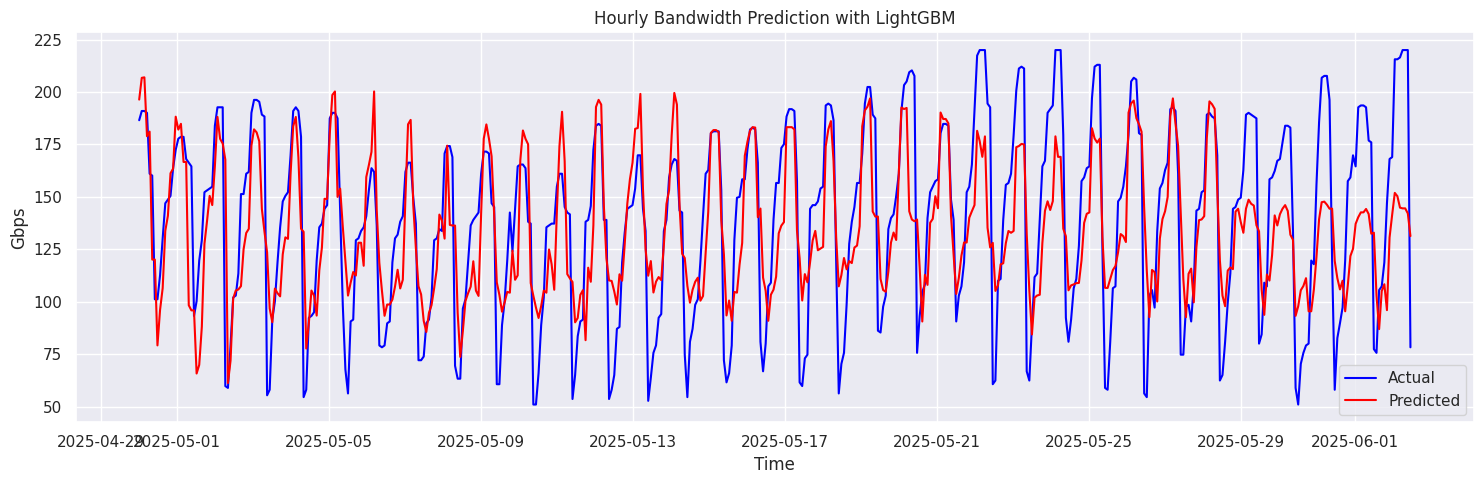

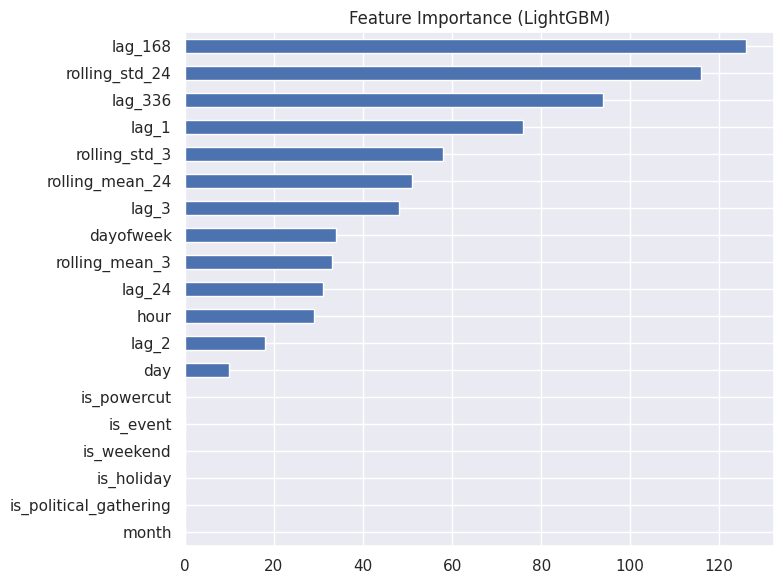

['bw_predictor_lgbm.pkl']

In [ ]:
# Hourly Bandwidth Prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import joblib

plt.style.use('fivethirtyeight')
sns.set()

# Load data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()

# Feature engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day
df['month'] = df.index.month


# Convert to int
for col in ['is_weekend','is_holiday', 'is_political_gathering',  'is_event',
            'is_powercut']:
    df[col] = df[col].astype(int)

# Lag features
for lag in [1, 2, 3, 24, 168, 336]:  # include 1-day, 7-day, 14-day lags
    df[f'lag_{lag}'] = df['Gbps'].shift(lag)

# Rolling features
df['rolling_mean_3'] = df['Gbps'].shift(1).rolling(window=3).mean()
df['rolling_std_3'] = df['Gbps'].shift(1).rolling(window=3).std()
df['rolling_mean_24'] = df['Gbps'].shift(1).rolling(window=24).mean()
df['rolling_std_24'] = df['Gbps'].shift(1).rolling(window=24).std()

# Drop missing
df = df.dropna()

# Train-test split
split_date = '2025-04-30'
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

# Features and target
FEATURES = ['hour', 'dayofweek', 'day', 'month', 'is_weekend', 'is_holiday',
            'is_political_gathering', 'is_event',  'is_powercut',
             'lag_1', 'lag_2', 'lag_3', 'lag_24', 'lag_168', 'lag_336',
            'rolling_mean_3', 'rolling_std_3', 'rolling_mean_24', 'rolling_std_24']
TARGET = 'Gbps'

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

# TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter grid for LightGBM
param_grid = {
    'n_estimators': [300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 8, 12],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# RandomizedSearchCV
model = LGBMRegressor(random_state=42)
search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=tscv,
                            scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

# Best model
model = search.best_estimator_
print("Best Parameters:", search.best_params_)

# Predict
test = test.copy()
test['prediction'] = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'Test RMSE: {rmse:.4f}')

# Plot predictions
plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, test['prediction'], label='Predicted', color='red')
plt.title('Hourly Bandwidth Prediction with LightGBM')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
feat_imp = pd.Series(model.feature_importances_, index=FEATURES).sort_values()
feat_imp.plot(kind='barh', title='Feature Importance (LightGBM)', figsize=(8, 6))
plt.tight_layout()
plt.show()

# Save model
joblib.dump(model, 'bw_predictor_lgbm.pkl')


# random forest

Test RMSE: 30.1021


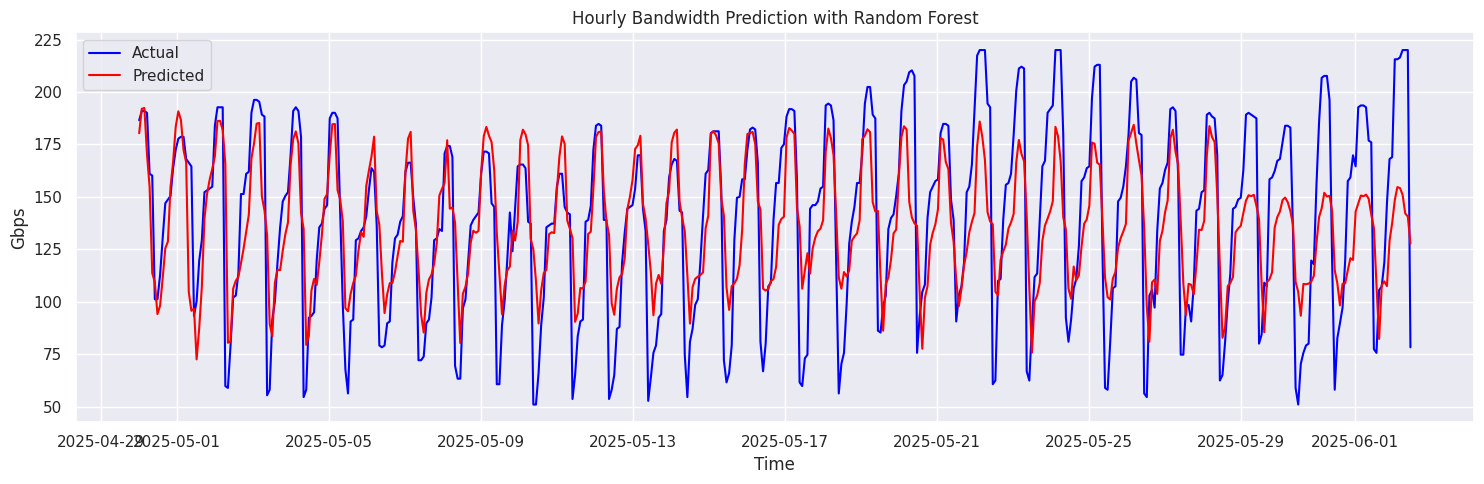

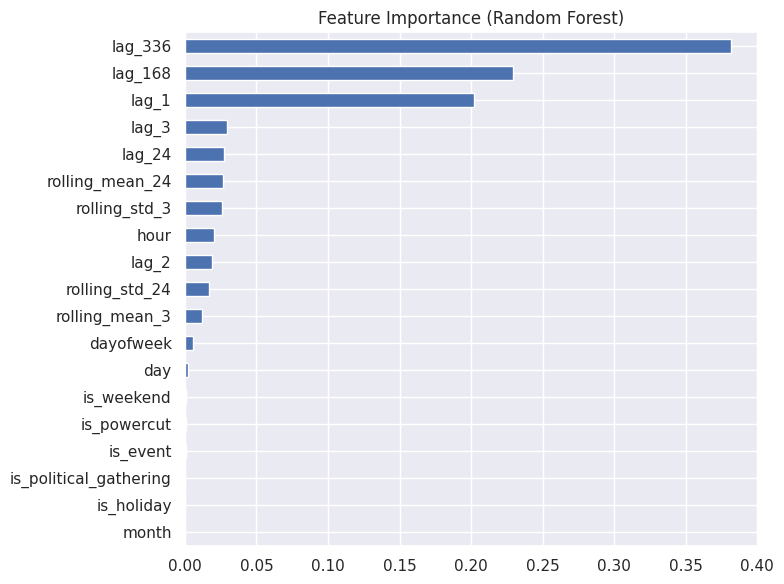

['bw_predictor_rf.pkl']

In [ ]:
# Hourly Bandwidth Prediction with Random Forest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import joblib

plt.style.use('fivethirtyeight')
sns.set()

# Load data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()

# Time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day
df['month'] = df.index.month


# Convert all event-type columns to integer
event_cols = ['is_weekend', 'is_holiday', 'is_political_gathering',  'is_event',
              'is_powercut']
for col in event_cols:
    df[col] = df[col].astype(int)

# Lag features: 1hr, 1d, 7d, 14d
for lag in [1, 2, 3, 24, 168, 336]:
    df[f'lag_{lag}'] = df['Gbps'].shift(lag)

# Rolling window features
df['rolling_mean_3'] = df['Gbps'].shift(1).rolling(window=3).mean()
df['rolling_std_3'] = df['Gbps'].shift(1).rolling(window=3).std()
df['rolling_mean_24'] = df['Gbps'].shift(1).rolling(window=24).mean()
df['rolling_std_24'] = df['Gbps'].shift(1).rolling(window=24).std()

# Drop missing rows
df = df.dropna()

# Train-test split
split_date = '2025-04-30'
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

# Feature list
FEATURES = ['hour', 'dayofweek', 'day', 'month', 'is_weekend',
            'is_holiday', 'is_political_gathering', 'is_event',
            'is_powercut',
            'lag_1', 'lag_2', 'lag_3', 'lag_24', 'lag_168', 'lag_336',
            'rolling_mean_3', 'rolling_std_3', 'rolling_mean_24', 'rolling_std_24']
TARGET = 'Gbps'

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

# Train Random Forest model
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predict
test = test.copy()
test['prediction'] = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'Test RMSE: {rmse:.4f}')

# Plot predictions
plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, test['prediction'], label='Predicted', color='red')
plt.title('Hourly Bandwidth Prediction with Random Forest')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=FEATURES).sort_values()
feat_imp.plot(kind='barh', title='Feature Importance (Random Forest)', figsize=(8, 6))
plt.tight_layout()
plt.show()

# Save model
joblib.dump(model, 'bw_predictor_rf.pkl')


# LSTM

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1633 - val_loss: 0.0733
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0746 - val_loss: 0.0707
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0637 - val_loss: 0.0660
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0622 - val_loss: 0.0644
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0609 - val_loss: 0.0607
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0548 - val_loss: 0.0550
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0523 - val_loss: 0.0446
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0423 - val_loss: 0.0279
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0261 - val_loss: 0.0183
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0203 - val_loss: 0.0143
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0195 - val_loss: 0.0156
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0202 - val_l

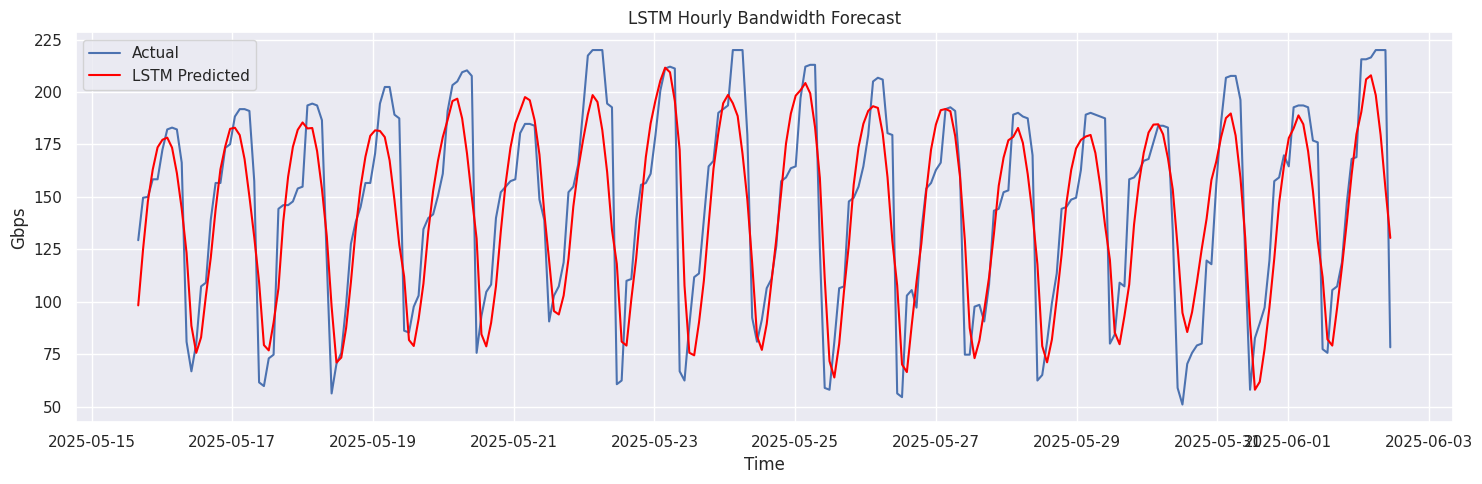

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()

# Keep only target
df = df[['Gbps']].copy()

# Normalize
scaler = MinMaxScaler()
df['Gbps_scaled'] = scaler.fit_transform(df[['Gbps']])

# Create sequences
def create_sequences(data, lookback=24):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 24  # 24 hours
data_values = df['Gbps_scaled'].values
X, y = create_sequences(data_values, lookback)

# Train-test split
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, 1), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'LSTM Test RMSE: {rmse:.4f}')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual')
plt.plot(df.index[-len(y_test):], y_pred, label='LSTM Predicted', color='red')
plt.title('LSTM Hourly Bandwidth Forecast')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# AR model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the po

AR Model RMSE: 38.1519


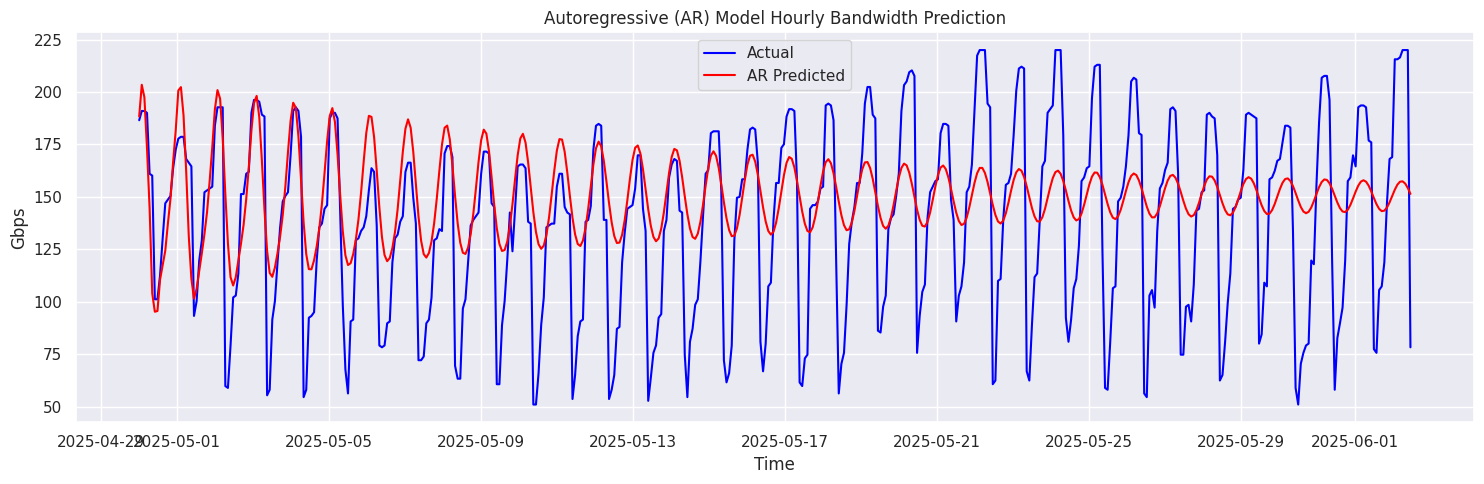

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
df = df[['Gbps']].copy()

# Train-test split
split_date = '2025-04-30'
train = df.loc[df.index < split_date, 'Gbps']
test = df.loc[df.index >= split_date, 'Gbps']

# Fit AR model
ar_lags = 24  # past 24 hours
model = AutoReg(train, lags=ar_lags, old_names=False)
model_fit = model.fit()

# Use integer indices
start_idx = len(train)
end_idx = start_idx + len(test) - 1

# Predict
predictions = model_fit.predict(start=start_idx, end=end_idx, dynamic=False)
predictions.index = test.index  # align index to test for plotting

# Evaluate
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'AR Model RMSE: {rmse:.4f}')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(predictions.index, predictions, label='AR Predicted', color='red')
plt.title('Autoregressive (AR) Model Hourly Bandwidth Prediction')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# arima

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA RMSE: 36.5433


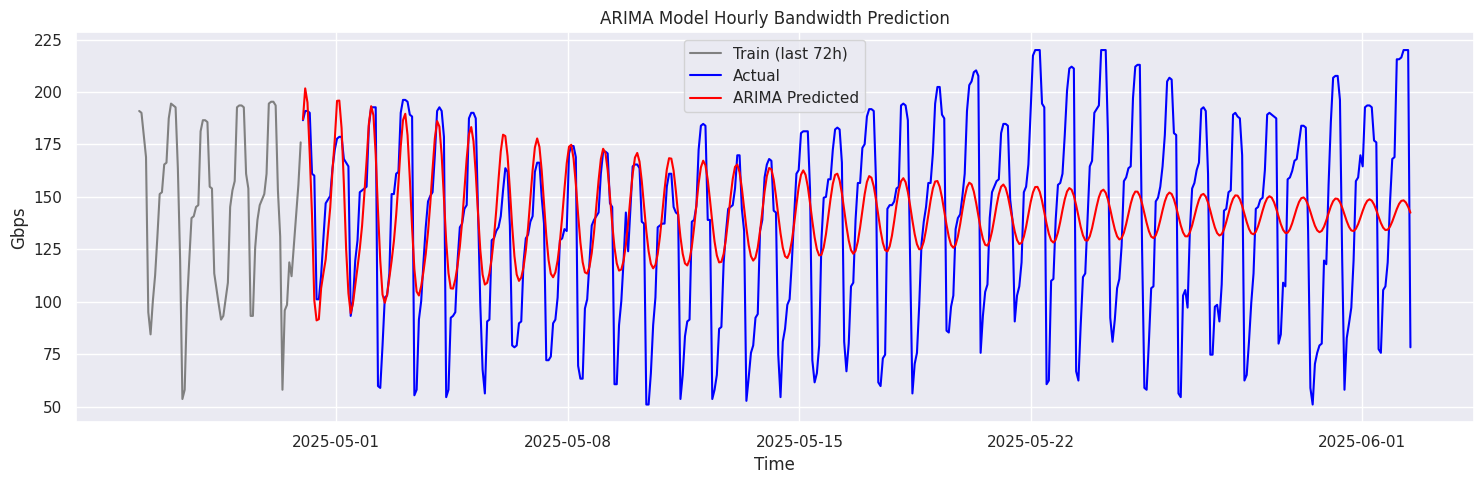

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load and prepare data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
df = df[['Gbps']].copy()

# Train-test split
split_date = '2025-04-30'
train = df.loc[df.index < split_date, 'Gbps']
test = df.loc[df.index >= split_date, 'Gbps']

# Fit ARIMA model (ARIMA(p,d,q))
# Example: AR(24), I(1), MA(0)
model = ARIMA(train, order=(24, 1, 0))
model_fit = model.fit()

# Predict (forecast len(test) steps ahead)
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

# Evaluate
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse:.4f}')

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(train.index[-72:], train[-72:], label='Train (last 72h)', color='gray')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='ARIMA Predicted', color='red')
plt.title('ARIMA Model Hourly Bandwidth Prediction')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


RNN

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.3256 - val_loss: 0.0210
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0251 - val_loss: 0.0172
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0184 - val_loss: 0.0137
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - val_loss: 0.0122
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0184 - val_loss: 0.0123
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0150 - val_loss: 0.0119
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0144 - val_loss: 0.0113
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - val_loss: 0.0113
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - val_loss: 0.0102
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - val_loss: 0.0102
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - val_loss: 0.0099
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - val_loss:

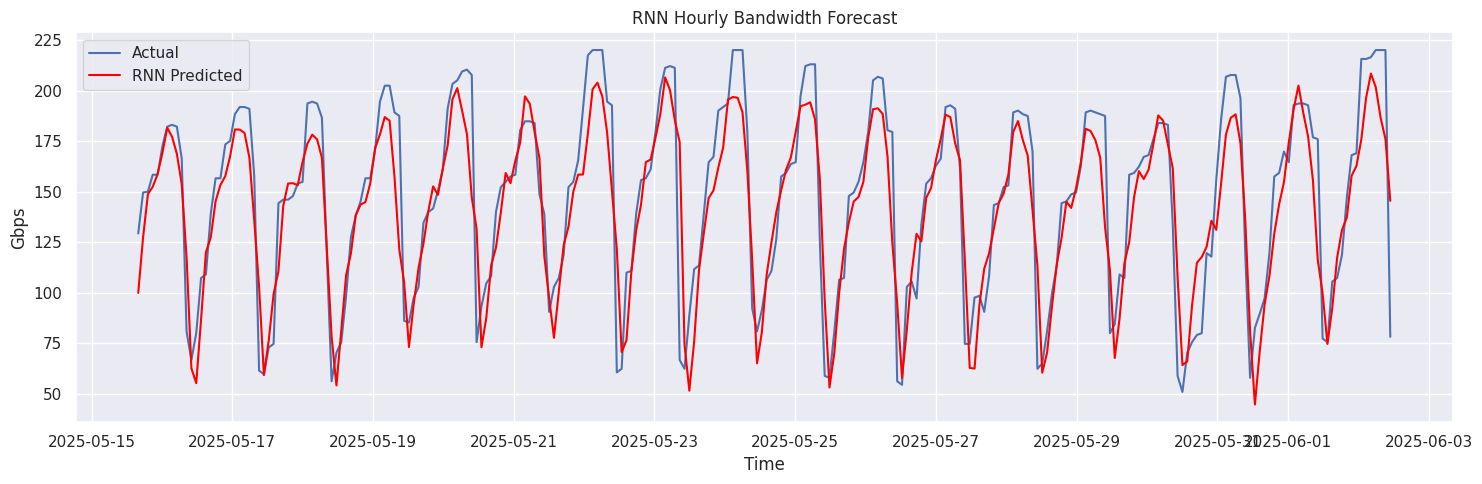

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
df = df[['Gbps']].copy()

# Normalize
scaler = MinMaxScaler()
df['Gbps_scaled'] = scaler.fit_transform(df[['Gbps']])

# Create sequences
def create_sequences(data, lookback=24):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 24  # 24-hour context window
data_values = df['Gbps_scaled'].values
X, y = create_sequences(data_values, lookback)

# Train-test split
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for RNN: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], lookback, 1))
X_test = X_test.reshape((X_test.shape[0], lookback, 1))

# Build RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(lookback, 1), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'RNN Test RMSE: {rmse:.4f}')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual')
plt.plot(df.index[-len(y_test):], y_pred, label='RNN Predicted', color='red')
plt.title('RNN Hourly Bandwidth Forecast')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# GRU


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1532 - val_loss: 0.0800
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0574 - val_loss: 0.0453
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0438 - val_loss: 0.0450
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0457 - val_loss: 0.0391
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0404 - val_loss: 0.0352
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0366 - val_loss: 0.0304
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0335 - val_loss: 0.0264
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0267 - val_loss: 0.0224
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0255 - val_loss: 0.0223
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0206 - val_loss: 0.0188
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0227 - val_loss: 0.0224
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0208 - val_l

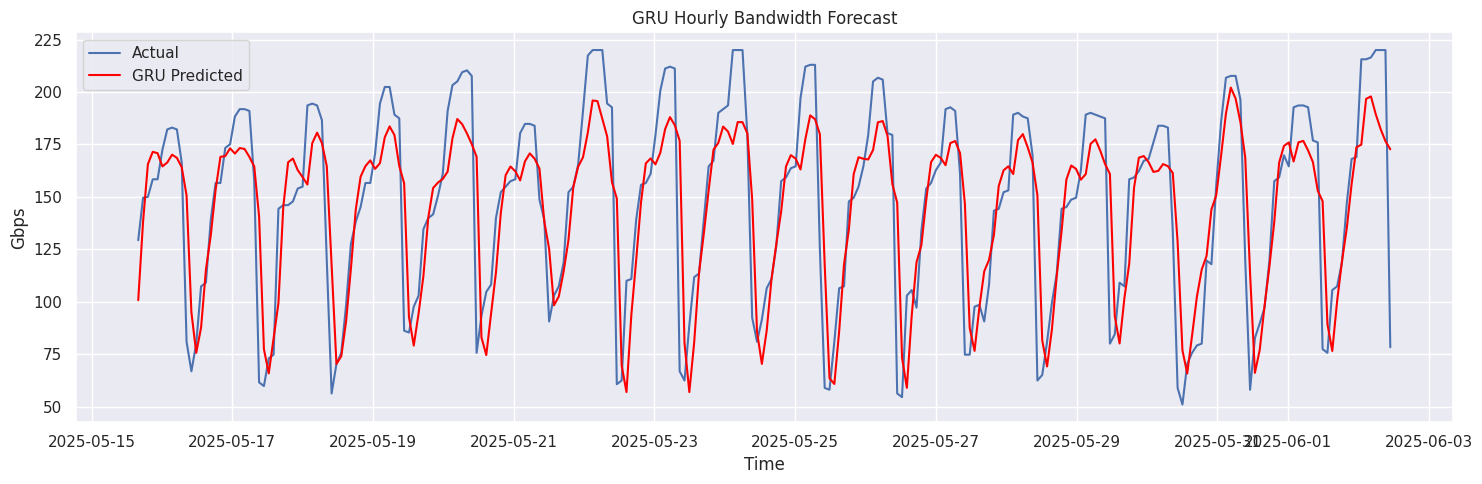

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
df = df[['Gbps']].copy()

# Normalize
scaler = MinMaxScaler()
df['Gbps_scaled'] = scaler.fit_transform(df[['Gbps']])

# Create sequences
def create_sequences(data, lookback=24):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 24  # 24-hour input window
data_values = df['Gbps_scaled'].values
X, y = create_sequences(data_values, lookback)

# Train-test split
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for GRU
X_train = X_train.reshape((X_train.shape[0], lookback, 1))
X_test = X_test.reshape((X_test.shape[0], lookback, 1))

# Build GRU model
model = Sequential()
model.add(GRU(64, input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'GRU Test RMSE: {rmse:.4f}')

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual')
plt.plot(df.index[-len(y_test):], y_pred, label='GRU Predicted', color='red')
plt.title('GRU Hourly Bandwidth Forecast')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# exponential

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Holt-Winters RMSE: 49.6037


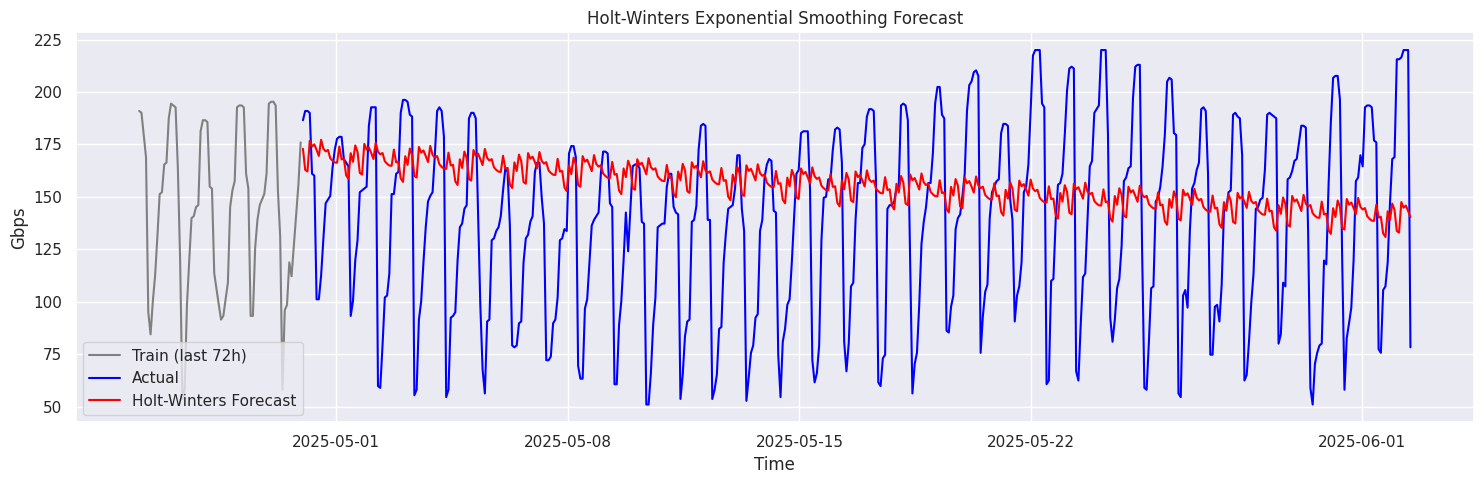

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
df = df[['Gbps']].copy()

# Train-test split
split_date = '2025-04-30'
train = df.loc[df.index < split_date, 'Gbps']
test = df.loc[df.index >= split_date, 'Gbps']

# Fit Holt-Winters (seasonal additive)
model = ExponentialSmoothing(train,
                             trend='add',
                             seasonal='add',
                             seasonal_periods=24)  # 24-hour seasonality
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(len(test))
forecast.index = test.index

# Evaluate
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'Holt-Winters RMSE: {rmse:.4f}')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(train.index[-72:], train[-72:], label='Train (last 72h)', color='gray')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Holt-Winters Forecast', color='red')
plt.title('Holt-Winters Exponential Smoothing Forecast')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# CNN

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1890 - val_loss: 0.0392
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0358 - val_loss: 0.0118
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0163 - val_loss: 0.0100
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - val_loss: 0.0102
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0169 - val_loss: 0.0101
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133 - val_loss: 0.0098
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - val_loss: 0.0096
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - val_loss: 0.0100
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0142 - val_loss: 0.0095
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - val_loss: 0.0097
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - val_loss: 0.0096
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - val_loss: 0.00

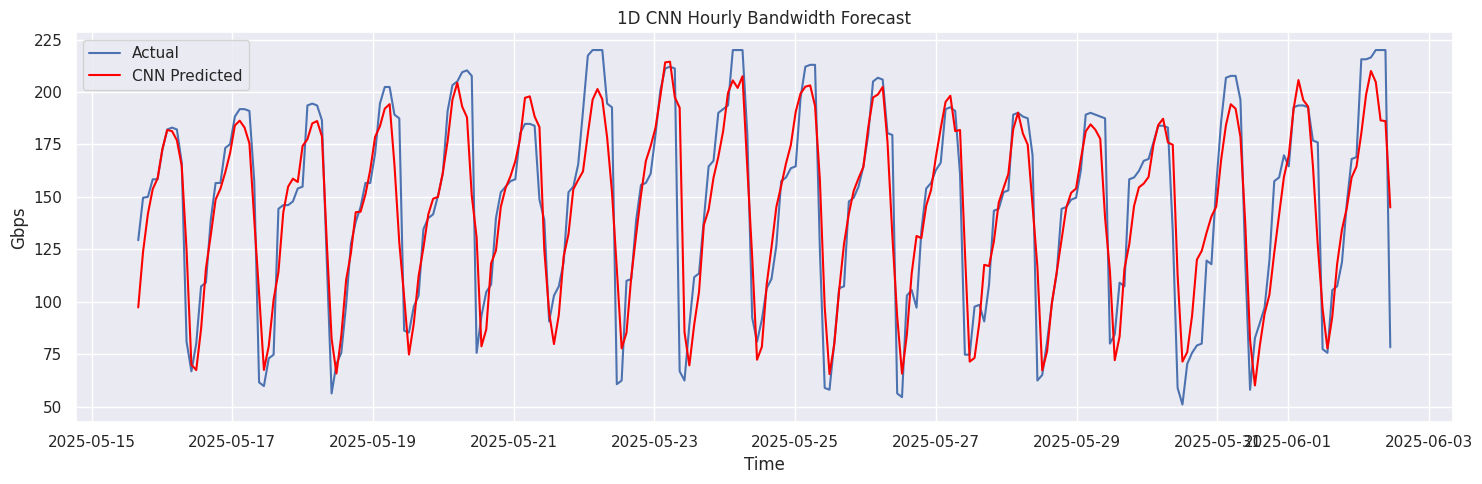

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
df = df[['Gbps']].copy()

# Normalize
scaler = MinMaxScaler()
df['Gbps_scaled'] = scaler.fit_transform(df[['Gbps']])

# Create sequences
def create_sequences(data, lookback=24):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 24
X, y = create_sequences(df['Gbps_scaled'].values, lookback)

# Train-test split
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for CNN [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train,
          epochs=30,
          batch_size=32,
          validation_split=0.1,
          callbacks=[early_stop],
          verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'CNN Test RMSE: {rmse:.4f}')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual')
plt.plot(df.index[-len(y_test):], y_pred, label='CNN Predicted', color='red')
plt.title('1D CNN Hourly Bandwidth Forecast')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
